<a href="https://colab.research.google.com/github/Seydifa/Challenge/blob/main/Torch_Version_de_CMI_idea_test_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

data_path = kagglehub.competition_download('cmi-detect-behavior-with-sensor-data')

print('Data source import complete.')

100%|██████████| 178M/178M [00:01<00:00, 120MB/s]

Extracting files...


Data source import complete.


In [3]:
from transformers.modeling_attn_mask_utils import AttentionMaskConverter
from transformers.models.t5.modeling_t5 import T5Attention, T5Config, T5LayerSelfAttention
from torchvision.transforms.functional import resize as torch_resize
from transformers import PretrainedConfig, PreTrainedModel
import torch.nn.functional as F
from torch import nn
import timm

from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import polars as pl
import numpy as np
import torch
import cv2
import os

import warnings
warnings.filterwarnings("ignore")

In [4]:
class CMIConfig(PretrainedConfig):
    def __init__(
        self,
        ctn_dim=25,
        static_dim=8,
        tof_dim=5,
        tof_length=64,
        sequence_length=16,
        do_resize=False,
        vision_backbone='resnet50d',
        num_classes=18,
        num_seq_classes=4,
        model_dim=512,
        hidden_dim=512,
        num_heads=8,
        num_layers=6,
        dropout=0.1,
        pretrained_weights=False,
        pad_token_id=-100,
        freeze_backbone=False,
        epsilon=1e-4,
      ):
        super().__init__()
        self.ctn_dim = ctn_dim
        self.static_dim = static_dim
        self.tof_dim = tof_dim
        self.tof_length = tof_length
        self.sequence_length = sequence_length
        self.do_resize = do_resize
        self.vision_backbone = vision_backbone
        self.num_classes = num_classes
        self.model_dim = model_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout
        self.pretrained_weights = pretrained_weights
        self.freeze_backbone = freeze_backbone
        self.epsilon = epsilon
        self.num_seq_classes = num_seq_classes
        self.pad_token_id = pad_token_id

In [5]:
df = pl.read_csv(os.path.join(data_path, 'train.csv'))
demographies_df = pl.read_csv(os.path.join(data_path, 'train_demographics.csv'))

In [77]:
def remove_gravity_vectorized(acc_data, quat_data):
    """
    Vectorized function to remove gravity from accelerometer data.

    Args:
        acc_data (np.ndarray): (N, 3) array of accelerometer readings.
        quat_data (np.ndarray): (N, 4) array of quaternion readings [x, y, z, w].

    Returns:
        np.ndarray: (N, 3) array of linear acceleration.
    """
    # Create a mask for valid quaternions to avoid errors with NaNs or zero quaternions
    valid_quat_mask = ~np.isnan(quat_data).any(axis=1) & ~np.all(quat_data == 0, axis=1)

    linear_accel = np.copy(acc_data)

    if np.any(valid_quat_mask):
        # Process only the valid quaternions
        valid_quats = quat_data[valid_quat_mask]

        # Create Rotation objects from the valid quaternions
        rotations = R.from_quat(valid_quats)

        # Define gravity in the world frame
        gravity_world = np.array([0, 0, 9.81])

        # Rotate the world gravity vector into each sensor's frame
        # This is equivalent to rotating the sensor's reading from sensor to world frame,
        # subtracting gravity, and rotating back. inverse=True is more direct.
        gravity_sensor_frame = rotations.apply(gravity_world, inverse=True)

        # Subtract the gravity component from the accelerometer data
        linear_accel[valid_quat_mask] = acc_data[valid_quat_mask] - gravity_sensor_frame

    return linear_accel

def calculate_angular_velocity_vectorized(quat_data, time_delta=1/200):
    """
    Vectorized function to calculate angular velocity from quaternions.

    Args:
        quat_data (np.ndarray): (N, 4) array of quaternion readings [x, y, z, w].
        time_delta (float): Time step between samples.

    Returns:
        np.ndarray: (N, 3) array of angular velocities.
    """
    # Ensure quaternions are normalized to avoid issues
    norms = np.linalg.norm(quat_data, axis=1)
    # Avoid division by zero for zero-quaternions
    non_zero_norms = norms > 1e-8
    quat_data[non_zero_norms] /= norms[non_zero_norms, np.newaxis]

    # Get rotations at time t and t+1
    rot_t = R.from_quat(quat_data[:-1])
    rot_t_plus_dt = R.from_quat(quat_data[1:])

    # Calculate the relative rotation between consecutive timesteps
    delta_rot = rot_t.inv() * rot_t_plus_dt

    # The rotation vector's direction is the axis of rotation, and its magnitude is the angle.
    # Angular velocity is this rotation vector divided by the time step.
    angular_vel = delta_rot.as_rotvec() / time_delta

    # Pad with a zero vector at the end to match the original length
    return np.pad(angular_vel, ((0, 1), (0, 0)), 'constant')

def engineer_features(raw_cnt_sequence):
    """
    Applies feature engineering to a raw sequence of IMU and Thermopile data.
    This function is pure-numpy for performance.

    Args:
        raw_cnt_sequence (np.ndarray): (L, C) array of raw data, where C includes
                                       acc, rot, and thermo channels in order.

    Returns:
        np.ndarray: (L, C_engineered) array with engineered features.
    """
    # --- Define column indices for clarity and robustness ---
    ACC_COLS = slice(0, 3)    # acc_x, acc_y, acc_z
    ROT_COLS = slice(3, 7)    # rot_w, rot_x, rot_y, rot_z (swapped to be SciPy compatible)
    QUAT_XYZW_COLS = [4, 5, 6, 3] # SciPy expects [x, y, z, w]

    # --- Extract base data ---
    acc_data = raw_cnt_sequence[:, ACC_COLS]
    # Reorder quaternion from [w, x, y, z] to [x, y, z, w] for SciPy
    quat_data_wxyz = raw_cnt_sequence[:, ROT_COLS]
    quat_data_xyzw = quat_data_wxyz[:, [1, 2, 3, 0]]

    # --- Feature Creation ---
    # 1. Accelerometer Magnitude
    acc_mag = np.linalg.norm(acc_data, axis=1, keepdims=True)

    # 2. Rotation Angle from Quaternion
    # Clip rot_w to [-1, 1] to avoid domain errors with arccos
    rot_w = np.clip(quat_data_wxyz[:, 0], -1.0, 1.0)
    rot_angle = (2 * np.arccos(rot_w)).reshape(-1, 1)

    # 3. Jerk (derivative of magnitude)
    acc_mag_jerk = np.pad(np.diff(acc_mag, axis=0), ((1, 0), (0, 0)), 'constant')

    # 4. Angular Velocity (from rotation angle)
    rot_angle_vel = np.pad(np.diff(rot_angle, axis=0), ((1, 0), (0, 0)), 'constant')

    # 5. Linear Acceleration (gravity removed)
    linear_accel = remove_gravity_vectorized(acc_data, quat_data_xyzw)

    # 6. Linear Acceleration Magnitude
    linear_acc_mag = np.linalg.norm(linear_accel, axis=1, keepdims=True)

    # 7. Linear Acceleration Jerk
    linear_acc_mag_jerk = np.pad(np.diff(linear_acc_mag, axis=0), ((1, 0), (0, 0)), 'constant')

    # 8. Angular Velocity (from quaternion differentiation)
    angular_vel = calculate_angular_velocity_vectorized(quat_data_xyzw)

    # --- Combine all features ---
    all_features = [
        raw_cnt_sequence,       # Original IMU + Thermo data
        acc_mag,
        rot_angle,
        acc_mag_jerk,
        rot_angle_vel,
        linear_accel,
        linear_acc_mag,
        linear_acc_mag_jerk,
        angular_vel,
    ]

    engineered_sequence = np.hstack(all_features)
    return np.nan_to_num(engineered_sequence, nan=0.0)

In [79]:
# ====================== Sensor Data Augmentation Classes ======================
# NOTE: The SensorDataAugmenter class is largely the same, but the rotation
#       augmentation is now more physically correct.
class SensorDataAugmenter:
    def __init__(self, augmentation_prob=0.7, training=True):
        self.augmentation_prob = augmentation_prob
        self.training = training

    def rotation_augmentation(self, raw_data, max_angle=10):
        """
        Applies a single, consistent random rotation to the entire sequence.
        Rotates both accelerometer and quaternion data.
        """
        if not self.training or np.random.random() > self.augmentation_prob:
            return raw_data

        augmented_data = raw_data.copy()

        # Define column indices
        ACC_COLS = slice(0, 3)
        ROT_COLS = slice(3, 7) # w, x, y, z

        # 1. Generate a single random rotation for the whole sequence
        random_rotation = R.from_euler('xyz', np.random.uniform(-max_angle, max_angle, 3), degrees=True)

        # 2. Rotate the accelerometer data
        acc_original = augmented_data[:, ACC_COLS]
        augmented_data[:, ACC_COLS] = random_rotation.apply(acc_original)

        # 3. Rotate the quaternion data
        quat_original_wxyz = augmented_data[:, ROT_COLS]
        quat_original_xyzw = quat_original_wxyz[:, [1, 2, 3, 0]] # to xyzw

        # Filter out invalid quaternions before creating Rotation objects
        valid_mask = ~np.isnan(quat_original_xyzw).any(axis=1) & (np.linalg.norm(quat_original_xyzw, axis=1) > 1e-6)

        # Apply rotation composition: new_orientation = random_rotation * old_orientation
        rotations_original = R.from_quat(quat_original_xyzw[valid_mask])
        rotations_augmented = random_rotation * rotations_original

        # Convert back to xyzw, then back to wxyz for storage
        quat_augmented_xyzw = rotations_augmented.as_quat()
        quat_augmented_wxyz = quat_augmented_xyzw[:, [3, 0, 1, 2]] # to wxyz

        ROT_COLS = list(range(3, 7))
        augmented_data[valid_mask, ROT_COLS[0]] = quat_augmented_wxyz[:, 0]
        augmented_data[valid_mask, ROT_COLS[1]] = quat_augmented_wxyz[:, 1]
        augmented_data[valid_mask, ROT_COLS[2]] = quat_augmented_wxyz[:, 2]
        augmented_data[valid_mask, ROT_COLS[3]] = quat_augmented_wxyz[:, 3]

        return augmented_data

    def add_gaussian_noise(self, data, noise_factor=0.02):
        """Add Gaussian noise scaled to signal magnitude"""
        if not self.training or np.random.random() > self.augmentation_prob:
            return data

        noise = np.random.normal(0, noise_factor * np.std(data, axis=0), data.shape)
        return data + noise

    def time_warping(self, data, sigma=0.2, num_knots=4):
        """Apply smooth time warping to simulate natural gesture timing variations"""
        if not self.training or np.random.random() > self.augmentation_prob:
            return data

        seq_len = data.shape[0]
        if seq_len < 4:  # Too short to warp
            return data

        # Create random warping curve
        knots = np.linspace(0, seq_len-1, num_knots)
        warps = np.random.normal(0, sigma * seq_len / 10, num_knots)  # Reduced warping strength

        # Smooth interpolation
        original_indices = np.arange(seq_len)
        warped_indices = np.interp(original_indices, knots, knots + warps)
        warped_indices = np.clip(warped_indices, 0, seq_len-1)

        # Interpolate data
        warped_data = np.zeros_like(data)
        for i in range(data.shape[1]):
            warped_data[:, i] = np.interp(original_indices, warped_indices, data[:, i])

        return warped_data

    def magnitude_scaling(self, data, scale_range=(0.9, 1.1)):
        """Scale signal magnitude while preserving relative relationships"""
        if not self.training or np.random.random() > self.augmentation_prob:
            return data

        scale_factors = np.random.uniform(scale_range[0], scale_range[1], data.shape[1])
        return data * scale_factors

    def sensor_dropout(self, data, dropout_prob=0.05, max_consecutive=3):
        """Simulate sensor communication failures"""
        if not self.training or np.random.random() > self.augmentation_prob:
            return data

        augmented_data = data.copy()
        seq_len = data.shape[0]

        for col in range(data.shape[1]):
            if np.random.random() < dropout_prob:
                # Random dropout length
                dropout_len = np.random.randint(1, min(max_consecutive + 1, seq_len // 4))
                start_idx = np.random.randint(0, max(1, seq_len - dropout_len))

                # Set to previous value or interpolate
                if start_idx > 0 and start_idx + dropout_len < seq_len:
                    # Linear interpolation
                    start_val = augmented_data[start_idx - 1, col]
                    end_val = augmented_data[start_idx + dropout_len, col]
                    interp_vals = np.linspace(start_val, end_val, dropout_len + 2)[1:-1]
                    augmented_data[start_idx:start_idx + dropout_len, col] = interp_vals
                else:
                    # Use previous value or zero
                    fill_val = augmented_data[start_idx - 1, col] if start_idx > 0 else 0
                    augmented_data[start_idx:start_idx + dropout_len, col] = fill_val

        return augmented_data

    def temperature_drift(self, thermo_data, drift_rate=0.005):
        """Simulate gradual temperature drift in thermopile sensors"""
        if not self.training or np.random.random() > self.augmentation_prob:
            return thermo_data

        seq_len = thermo_data.shape[0]
        time_steps = np.arange(seq_len)

        # Random drift parameters
        drift_direction = np.random.choice([-1, 1], thermo_data.shape[1])
        drift_magnitude = np.random.uniform(0, drift_rate, thermo_data.shape[1])

        # Apply linear drift
        drift = np.outer(time_steps, drift_direction * drift_magnitude)

        return thermo_data + drift

    # ... (add_gaussian_noise, time_warping, etc. can remain mostly the same) ...
    # Make sure they operate on NumPy arrays, which they already do.

    def augment_cnt_sequence(self, raw_cnt_sequence):
        """
        Applies a chain of augmentations to the raw continuous sensor data.
        """
        if not self.training:
            return raw_cnt_sequence

        augmented_cnt = raw_cnt_sequence.copy()

        # 1. Apply rotation first as it affects multiple columns consistently
        augmented_cnt = self.rotation_augmentation(augmented_cnt)

        # 2. Apply imu augmentation
        imu_indices = slice(0, 7)
        augmented_cnt[:, imu_indices] = self.add_gaussian_noise(augmented_cnt[:, imu_indices], noise_factor=0.01)
        augmented_cnt[:, imu_indices] = self.time_warping(augmented_cnt[:, imu_indices], sigma=0.02, num_knots=4)
        augmented_cnt[:, imu_indices] = self.magnitude_scaling(augmented_cnt[:, imu_indices], scale_range=(0.9, 1.1))

        # 3. Apply Thermo augmentation
        thermo_indices = slice(7, 12)
        augmented_cnt[:, thermo_indices] = self.add_gaussian_noise(augmented_cnt[:, thermo_indices], noise_factor=0.005)
        augmented_cnt[:, thermo_indices] = self.temperature_drift(augmented_cnt[:, thermo_indices])
        augmented_cnt[:, thermo_indices] = self.sensor_dropout(augmented_cnt[:, thermo_indices], dropout_prob=0.05, max_consecutive=3)

        return augmented_cnt

    def augment_tof_sequence(self, tof_sequence):
        """Augment ToF sensor data"""
        if not self.training:
            return tof_sequence

        augmented_tof = tof_sequence.copy()
        augmented_tof = self.add_gaussian_noise(augmented_tof, noise_factor=0.02)

        for i in range(5):
          augmented_tof[..., i] = self.time_warping(augmented_tof[..., i], sigma=0.15, num_knots=4)

        augmented_tof = self.sensor_dropout(augmented_tof, dropout_prob=0.1, max_consecutive=3)
        return augmented_tof.astype(np.uint8)

In [81]:
# ====================== PyTorch Dataset ======================
class CMIDataset(Dataset):
    def __init__(
        self,
        df,
        demographies_df,
        max_sequence_length=500,
        label_col='gesture',
        label2idx=None,
        cache=True,
        training=False,
        augmentation_prob=0.7
    ):
        self.max_sequence_length = max_sequence_length
        self.label2idx = label2idx
        self.cache = cache
        self.training = training

        self.augmenter = SensorDataAugmenter(
            augmentation_prob=augmentation_prob, training=training
        )

        # Define raw feature columns to be extracted
        self.IMU_FEATURES = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z']
        self.THERMO_FEATURES = [f'thm_{i}' for i in range(1, 6)]
        self.RAW_CNT_COLS = self.IMU_FEATURES + self.THERMO_FEATURES
        self.TOF_COLS = [f"tof_{s}_v{i}" for s in range(1, 6) for i in range(64)]
        self._demo_static_cols = ['age', 'height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm', 'adult_child', 'sex', 'handedness']

        # Pre-process and cache all data into NumPy arrays for speed
        self._cache_data(df, demographies_df, label_col)

    def _cache_data(self, df, demographies_df, label_col):
        """Extracts all data from DataFrames and caches it into NumPy arrays."""
        print("Preprocessing and caching data...")
        self._cached_raw_cnt = []
        self._cached_tof = []
        self._cached_static = []
        self._cached_labels = []

        # Use Polars for fast grouping if available
        is_polars = isinstance(df, pl.DataFrame)

        if not is_polars:
            df = pl.from_pandas(df)
            demographies_df = pl.from_pandas(demographies_df)

        # Join demographic data once
        df = df.join(demographies_df, on='subject', how='left')

        for idx, group in tqdm(df.group_by('sequence_id'), total=df['sequence_id'].n_unique()):
            # 1. Continuous Raw Data
            raw_cnt_seq = group.select(self.RAW_CNT_COLS).to_numpy()

            # 2. ToF Data
            tof_sequences = []
            for sensor_id in range(1, 6):
                tof_columns = [f"tof_{sensor_id}_v{i}" for i in range(64)]
                sequence = group.select(tof_columns).to_numpy()
                tof_sequences.append(sequence)
            tof_seq = np.stack(tof_sequences, axis=-1)
            tof_seq = np.uint8(tof_seq + 1)

            # 3. Static Demo Data
            static_vec = group.select(self._demo_static_cols).head(1).to_numpy().flatten()

            # 4. Label
            label = self.label2idx[group.select(label_col).head(1).item()]

            if self.cache:
                self._cached_raw_cnt.append(raw_cnt_seq)
                self._cached_tof.append(tof_seq)
                self._cached_static.append(static_vec)
                self._cached_labels.append(self._one_hot(label, len(self.label2idx)))

    def _pad_or_truncate(self, sequence, target_length):
        """Pads or truncates a sequence to a target length."""
        length = sequence.shape[0]
        if length < target_length:
            pad_width = [(0, target_length - length)] + [(0, 0)] * (sequence.ndim - 1)
            return np.pad(sequence, pad_width, mode='constant', constant_values=0)
        else:
            return sequence[:target_length]

    def __len__(self):
        return len(self._cached_raw_cnt)

    def _one_hot(self, label, num_classes):
        one_hot = np.zeros(num_classes)
        one_hot[label] = 1
        return one_hot

    def set_training_mode(self, training):
        self.training = training
        self.augmenter.training = training

    def __getitem__(self, idx):
        # 1. Load RAW data from cache (use .copy() to avoid modifying cache)
        raw_cnt_sequence = self._cached_raw_cnt[idx].copy()
        tof_sequence = self._cached_tof[idx].copy()
        static_vec = self._cached_static[idx].copy()
        label = self._cached_labels[idx].copy()

        # 2. Apply Augmentation (on raw data if in training mode)
        if self.training:
            raw_cnt_sequence = self.augmenter.augment_cnt_sequence(raw_cnt_sequence)
            tof_sequence = self.augmenter.augment_tof_sequence(tof_sequence) # Optional

        # 3. Perform Feature Engineering (on potentially augmented data)
        cnt_sequence = engineer_features(raw_cnt_sequence)

        # 4. Pad or truncate sequences to max_sequence_length
        cnt_sequence = self._pad_or_truncate(cnt_sequence, self.max_sequence_length)
        tof_sequence = self._pad_or_truncate(tof_sequence, self.max_sequence_length)

        # 5. Create padding mask from the final engineered sequence
        padding_mask = np.any(np.not_equal(cnt_sequence, 0), axis=-1)

        # 6. Transpose ToF for Conv2D (Channels, Height, Width)
        # Assuming model expects (Sensors, Time, Features) -> (5, L, 64)
        tof_sequence = np.transpose(tof_sequence, (2, 0, 1))

        inputs = {
            'cnt_sequence': torch.from_numpy(cnt_sequence).float(),
            'tof_sequence': torch.from_numpy(tof_sequence).float(),
            'static': torch.from_numpy(static_vec).float(),
            'padding_mask': torch.from_numpy(padding_mask).bool(),
            'labels': torch.from_numpy(label).float()
        }

        return inputs

In [85]:
label12idx = {label: idx for idx, label in enumerate(df['gesture'].unique())}
ds = CMIDataset(df, demographies_df, max_sequence_length=128, label2idx=label12idx, training=True, augmentation_prob=0.7)

Preprocessing and caching data...


  0%|          | 0/8151 [00:00<?, ?it/s]

In [86]:
ds.augmenter = SensorDataAugmenter(augmentation_prob=0.7, training=True)
inputs = next(iter(ds))

In [87]:
inputs['cnt_sequence'].shape, inputs['tof_sequence'].shape, inputs['static'].shape, inputs['padding_mask'].shape, inputs['labels'].shape

(torch.Size([128, 24]),
 torch.Size([5, 128, 64]),
 torch.Size([7]),
 torch.Size([128]),
 torch.Size([18]))

In [ ]:
def remove_gravity_from_acc(acc_data, rot_data):

    if isinstance(acc_data, pd.DataFrame):
        acc_values = acc_data[['acc_x', 'acc_y', 'acc_z']].values
    else:
        acc_values = acc_data

    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data

    num_samples = acc_values.shape[0]
    linear_accel = np.zeros_like(acc_values)

    gravity_world = np.array([0, 0, 9.81])

    for i in range(num_samples):
        if np.all(np.isnan(quat_values[i])) or np.all(np.isclose(quat_values[i], 0)):
            linear_accel[i, :] = acc_values[i, :]
            continue

        try:
            rotation = R.from_quat(quat_values[i])
            gravity_sensor_frame = rotation.apply(gravity_world, inverse=True)
            linear_accel[i, :] = acc_values[i, :] - gravity_sensor_frame
        except ValueError:
             linear_accel[i, :] = acc_values[i, :]

    return linear_accel

def calculate_angular_velocity_from_quat(rot_data, time_delta=1/200): # Assuming 200Hz sampling rate
    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data

    num_samples = quat_values.shape[0]
    angular_vel = np.zeros((num_samples, 3))

    for i in range(num_samples - 1):
        q_t = quat_values[i]
        q_t_plus_dt = quat_values[i+1]

        if np.all(np.isnan(q_t)) or np.all(np.isclose(q_t, 0)) or \
           np.all(np.isnan(q_t_plus_dt)) or np.all(np.isclose(q_t_plus_dt, 0)):
            continue

        try:
            rot_t = R.from_quat(q_t)
            rot_t_plus_dt = R.from_quat(q_t_plus_dt)

            # Calculate the relative rotation
            delta_rot = rot_t.inv() * rot_t_plus_dt

            # Convert delta rotation to angular velocity vector
            # The rotation vector (Euler axis * angle) scaled by 1/dt
            # is a good approximation for small delta_rot
            angular_vel[i, :] = delta_rot.as_rotvec() / time_delta
        except ValueError:
            # If quaternion is invalid, angular velocity remains zero
            pass

    return angular_vel


def calculate_angular_distance(rot_data):
    if isinstance(rot_data, pd.DataFrame):
        quat_values = rot_data[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    else:
        quat_values = rot_data

    num_samples = quat_values.shape[0]
    angular_dist = np.zeros(num_samples)

    for i in range(num_samples - 1):
        q1 = quat_values[i]
        q2 = quat_values[i+1]

        if np.all(np.isnan(q1)) or np.all(np.isclose(q1, 0)) or \
           np.all(np.isnan(q2)) or np.all(np.isclose(q2, 0)):
            angular_dist[i] = 0 # Или np.nan, в зависимости от желаемого поведения
            continue
        try:
            # Преобразование кватернионов в объекты Rotation
            r1 = R.from_quat(q1)
            r2 = R.from_quat(q2)

            # Вычисление углового расстояния: 2 * arccos(|real(p * q*)|)
            # где p* - сопряженный кватернион q
            # В scipy.spatial.transform.Rotation, r1.inv() * r2 дает относительное вращение.
            # Угол этого относительного вращения - это и есть угловое расстояние.
            relative_rotation = r1.inv() * r2

            # Угол rotation vector соответствует угловому расстоянию
            # Норма rotation vector - это угол в радианах
            angle = np.linalg.norm(relative_rotation.as_rotvec())
            angular_dist[i] = angle
        except ValueError:
            angular_dist[i] = 0 # В случае недействительных кватернионов
            pass

    return angular_dist

def group_ing(df, max_sequence_length=None):
    IMU_FEATURES = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z']
    THERMO_FEATURES = [f'thm_{i}' for i in range(1, 6)]
    SEQ_COLS = IMU_FEATURES + THERMO_FEATURES
    if hasattr(df, 'to_pandas'):
        df = df.to_pandas()
    df = df[SEQ_COLS].copy()
    df['acc_mag'] = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)
    df['rot_angle'] = 2 * np.arccos(df['rot_w'].clip(-1, 1))
    SEQ_COLS += ['acc_mag', 'rot_angle']
    df['acc_mag_jerk'] = df['acc_mag'].diff().fillna(0)
    df['rot_angle_vel'] = df['rot_angle'].diff().fillna(0)
    SEQ_COLS += ['acc_mag_jerk', 'rot_angle_vel']
    acc_data_group = df[['acc_x', 'acc_y', 'acc_z']]
    rot_data_group = df[['rot_x', 'rot_y', 'rot_z', 'rot_w']]
    linear_accel = remove_gravity_from_acc(acc_data_group, rot_data_group)
    df_linear_accel = pd.DataFrame(linear_accel, columns=['linear_acc_x', 'linear_acc_y', 'linear_acc_z'], index=df.index)
    df = pd.concat([df, df_linear_accel], axis=1)
    SEQ_COLS += ['linear_acc_x', 'linear_acc_y', 'linear_acc_z']
    df['linear_acc_mag'] = np.sqrt(df['linear_acc_x']**2 + df['linear_acc_y']**2 + df['linear_acc_z']**2)
    df['linear_acc_mag_jerk'] = df['linear_acc_mag'].diff().fillna(0)
    SEQ_COLS += ['linear_acc_mag', 'linear_acc_mag_jerk']
    angular_vel = calculate_angular_velocity_from_quat(rot_data_group)
    df_angular_vel = pd.DataFrame(angular_vel, columns=['angular_vel_x', 'angular_vel_y', 'angular_vel_z'], index=df.index)
    df = pd.concat([df, df_angular_vel], axis=1)
    SEQ_COLS += ['angular_vel_x', 'angular_vel_y', 'angular_vel_z']
    angular_dist_group = calculate_angular_distance(rot_data_group)
    df_angular_distance = pd.DataFrame(angular_dist_group, columns=['angular_distance'], index=df.index)
    df = pd.concat([df, df_angular_distance], axis=1)
    SEQ_COLS += ['angular_distance']
    sequence = df[SEQ_COLS].values
    sequence = np.nan_to_num(sequence, nan=0.0)
    if max_sequence_length:
        length = sequence.shape[0]
        if length < max_sequence_length:
            pad_width = [(0, max_sequence_length - sequence.shape[0])] + [(0, 0)] * (sequence.ndim - 1)
            sequence = np.pad(sequence, pad_width, mode='constant', constant_values=0)
        else:
            sequence = sequence[:max_sequence_length]
    return sequence

class CMIDataset(Dataset):
    def __init__(
          self,
          df,
          demographies_df,
          max_sequence_length=None,
          do_resize=False,
          group_id='sequence_id',
          label_col='gesture',
          label_seq='phase',
          label2idx=None,
          cache=False
        ):
        self.df = df.clone() if isinstance(df, pl.DataFrame) else df.copy()
        self.group_id = group_id
        self.demographies_df = demographies_df
        self.max_sequence_length = max_sequence_length
        self.do_resize = do_resize
        self._ids = self.df[self.group_id].unique()
        self.label_col = label_col
        self.label_seq = label_seq
        self.label2idx = label2idx
        self.cache = cache

        if self.label2idx is None:
            self.label2idx = {label: idx for idx, label in enumerate(self.df[self.label_col].unique())}

        self._demo_static_cols = ['age', 'height_cm', 'shoulder_to_wrist_cm', 'elbow_to_wrist_cm', 'adult_child', 'sex', 'handedness']

        if cache:
            self._tof_data    = []
            self._cnt_data    = []
            self._static_vecs = []
            self._labels      = []
            self._labels_seq  = []
            self._masks       = []
            for idx in tqdm(range(len(self)), desc='Caching data'):
                inputs = self._pipeline_(idx)
                self._tof_data.append(inputs['tof_sequence'])
                self._cnt_data.append(inputs['cnt_sequence'])
                self._static_vecs.append(inputs['static'])
                self._labels.append(inputs['labels'])
                self._masks.append(inputs['padding_mask'])

    def _prepare_tof_data(self, df_grouped, max_sequence_length=None, do_resize=False):
        tof_sequences = []
        for sensor_id in range(1, 6):
            tof_columns = [f"tof_{sensor_id}_v{i}" for i in range(64)]
            if hasattr(df_grouped, 'to_numpy'):
                sequence = df_grouped[tof_columns].to_numpy()
            else:
                sequence = df_grouped[tof_columns].values
            tof_sequences.append(sequence)

        tof_sequences = np.stack(tof_sequences, axis=-1)
        tof_sequences = np.uint8(tof_sequences+1)
        if max_sequence_length:
            if do_resize:
                tof_sequences = cv2.resize(tof_sequences, (tof_sequences.shape[1], max_sequence_length), interpolation=cv2.INTER_CUBIC)
            else:
                length = tof_sequences.shape[0]
                if length < max_sequence_length:
                    pad_width = [(0, max_sequence_length - tof_sequences.shape[0])] + [(0, 0)] * (tof_sequences.ndim - 1)
                    tof_sequences = np.pad(tof_sequences, pad_width, mode='constant', constant_values=0)
                else:
                    tof_sequences = tof_sequences[:max_sequence_length]
        return tof_sequences

    def __len__(self):
        return len(self._ids)

    def _compute_attention_mask(self, sequence):
        return np.any(np.not_equal(sequence, 0), axis=-1)

    def _label_seq(self, phase):
        if not isinstance(phase, list):
            phase = list(phase)
        label_seq = ['START'] + phase + ['END'] + ['PAD'] * (self.max_sequence_length - len(phase)-2)
        return self.labelseqencoder.transform(label_seq)[:self.max_sequence_length]

    def _pipeline_(self, idx):
        if isinstance(self.df, pl.DataFrame):
            group_df = self.df.filter(pl.col(self.group_id) == self._ids[idx])
            demo_df = self.demographies_df.filter(pl.col('subject') == group_df['subject'].first())
        else:
            group_df = self.df[self.df[self.group_id] == self._ids[idx]]
            demo_df = self.demographies_df[self.demographies_df['subject'] == group_df['subject'].iloc[0]]
        tof_sequence = self._prepare_tof_data(group_df, max_sequence_length=self.max_sequence_length, do_resize=self.do_resize)
        cnt_sequence = group_ing(group_df, max_sequence_length=self.max_sequence_length)
        demo_static = demo_df[self._demo_static_cols].to_numpy() if hasattr(demo_df, 'to_numpy') else demo_df[self._demo_static_cols].values
        static = demo_static.flatten()
        padding_mask = self._compute_attention_mask(cnt_sequence)
        tof_sequence = np.transpose(tof_sequence, (2, 0, 1))
        inputs = {'tof_sequence': tof_sequence, 'cnt_sequence': cnt_sequence, 'static': static, 'padding_mask': padding_mask}
        inputs['labels'] = self.label2idx[group_df[self.label_col].first()]
        inputs['labels'] = self._one_hot(inputs['labels'], len(self.label2idx))
        return inputs

    def __getitem__(self, idx):
        if self.cache:
            inputs = {
                'tof_sequence': self._tof_data[idx],
                'cnt_sequence': self._cnt_data[idx],
                'static': self._static_vecs[idx],
                'padding_mask': self._masks[idx],
            }
            inputs['labels'] = self._labels[idx]
        else:
            inputs = self._pipeline_(idx)
        inputs = {k: torch.from_numpy(v).float() for k, v in inputs.items()}
        return inputs

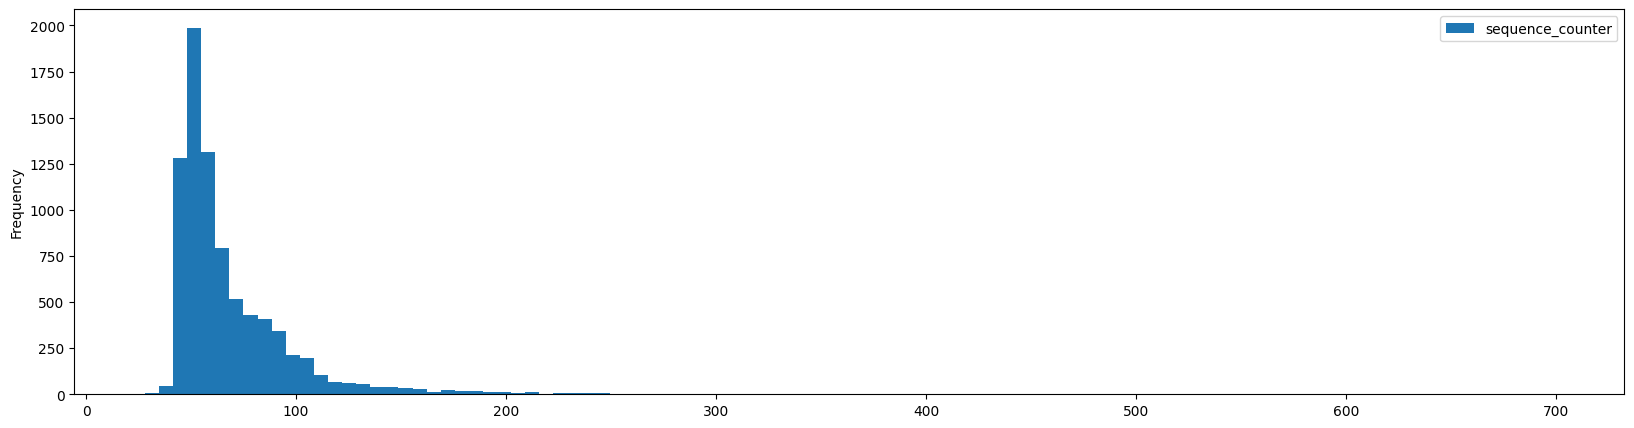

In [ ]:
dff = df.group_by('sequence_id').agg(pl.col('sequence_counter').max()).to_pandas()
fig = plt.figure(figsize=(20, 5), dpi=100)
dff.plot(kind='hist', bins=100, ax=fig.add_subplot())
plt.show()

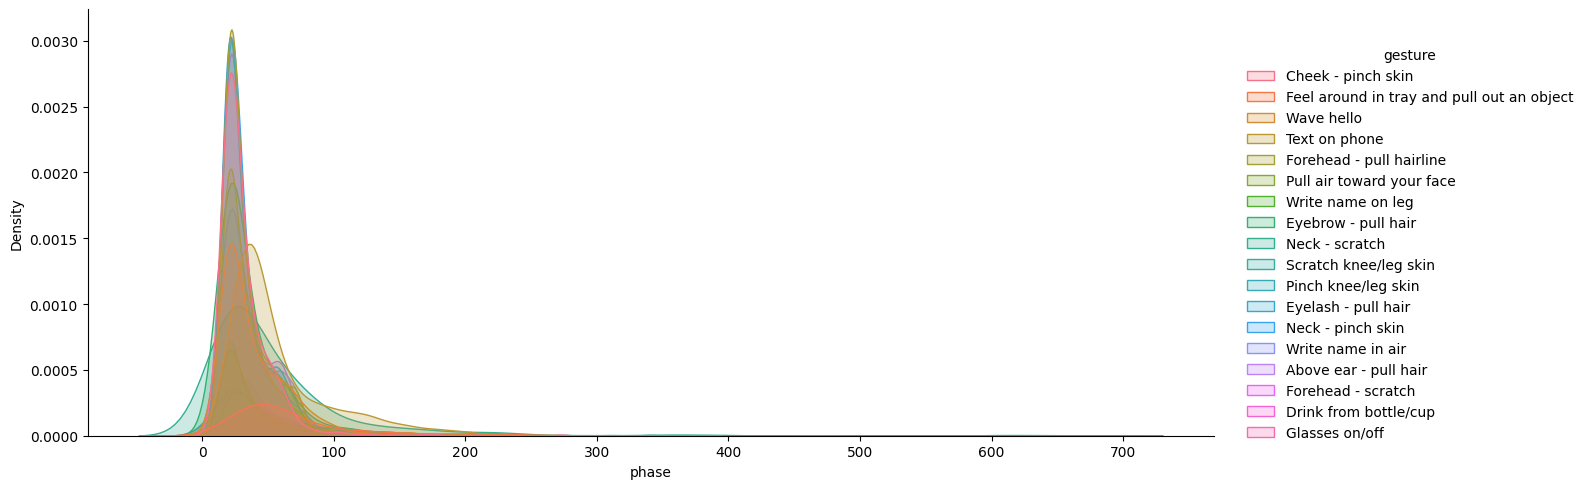

In [ ]:
dff = df.group_by('sequence_id').agg(pl.col('phase').filter(pl.col('phase') == 'Transition').count(), pl.col('gesture').first()).to_pandas()
sns.displot(dff, x='phase', hue='gesture', kind='kde', fill=True, aspect=2.5)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sequence_df = df.group_by('sequence_id').agg(pl.col('gesture').first())
sequence_id = sequence_df['sequence_id'].to_numpy()
sequence_label = LabelEncoder().fit_transform(sequence_df['gesture'].to_numpy())
train_ids, dev_ids = train_test_split(sequence_id, test_size=0.35, random_state=42, stratify=sequence_label)
val_ids, test_ids = train_test_split(dev_ids, test_size=0.5, random_state=42)

if isinstance(df, pl.DataFrame):
    df_train = df.filter(pl.col('sequence_id').is_in(train_ids))
    df_valid = df.filter(pl.col('sequence_id').is_in(val_ids))
    df_test = df.filter(pl.col('sequence_id').is_in(test_ids))
else:
    df_train = df[df['sequence_id'].isin(train_ids)]
    df_valid = df[df['sequence_id'].isin(val_ids)]
    df_test = df[df['sequence_id'].isin(test_ids)]

MAX_SEQ = 128
label_seq_encoder = LabelEncoder().fit(np.asarray(['START', 'Transition', 'Gesture', 'END', 'PAD']))

train_dataset = CMIDataset(
    df_train,
    demographies_df,
    group_id='sequence_id',
    label_col='gesture',
    max_sequence_length=MAX_SEQ,
    labelseqencoder=label_seq_encoder,
    do_resize=False,
    jitter_prob=0.25,
    channel_shuffle_prob=0.15,
    shift_prob=0.0,
    max_shift=10,
    alpha=0.2,
    cache=True
)

val_dataset = CMIDataset(
    df_valid,
    demographies_df,
    group_id='sequence_id',
    label_col='gesture',
    max_sequence_length=MAX_SEQ,
    do_resize=False,
    label2idx=train_dataset.label2idx,
    labelseqencoder=label_seq_encoder,
    alpha=0.0,
    cache=True
)
test_dataset = CMIDataset(
    df_test,
    demographies_df,
    group_id='sequence_id',
    label_col='gesture',
    max_sequence_length=MAX_SEQ,
    do_resize=False,
    label2idx=train_dataset.label2idx,
    labelseqencoder=label_seq_encoder,
    alpha=0.0,
    cache=True
)

Caching data:   0%|          | 0/5298 [00:00<?, ?it/s]

Caching data:   0%|          | 0/1426 [00:00<?, ?it/s]

Caching data:   0%|          | 0/1427 [00:00<?, ?it/s]

In [ ]:
next(iter(train_dataset))

{'tof_sequence': tensor([[[224.,   0.,   0.,  ...,   0.,   0.,   0.],
          [210.,   0.,   0.,  ...,   0.,   0.,   0.],
          [198.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],
 
         [[213.,   0.,   0.,  ...,   0.,   0.,   0.],
          [213.,   0.,   0.,  ...,   0.,   0.,   0.],
          [196.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],
 
         [[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.

In [ ]:
config = CMIConfig(
      static_dim=7,
      ctn_dim=25,
      tof_dim=5,
      tof_length=64,
      sequence_length=MAX_SEQ,
      do_resize=False,
      num_classes=len(train_dataset.label2idx),
      num_seq_classes=len(label_seq_encoder.classes_),
      model_dim=512,
      hidden_dim=1024,
      num_heads=8,
      num_layers=6,
      dropout=0.25,
      pretrained_weights=True,
      freeze_backbone=False,
      vision_backbone='timm/convnext_tiny.in12k_ft_in1k_384',
      epsilon=1e-6,
      pad_token_id=int(label_seq_encoder.transform(['PAD'])[0])
)
config

CMIConfig {
  "ctn_dim": 25,
  "do_resize": false,
  "dropout": 0.25,
  "epsilon": 1e-06,
  "freeze_backbone": false,
  "hidden_dim": 1024,
  "model_dim": 512,
  "num_classes": 18,
  "num_heads": 8,
  "num_layers": 6,
  "num_seq_classes": 5,
  "pad_token_id": 2,
  "pretrained_weights": true,
  "sequence_length": 128,
  "static_dim": 7,
  "tof_dim": 5,
  "tof_length": 64,
  "transformers_version": "4.53.2",
  "vision_backbone": "timm/convnext_tiny.in12k_ft_in1k_384"
}

In [ ]:
sample = train_dataset[1]

In [ ]:
for k, v in sample.items():
    print(k, v.shape)

tof_sequence torch.Size([5, 128, 64])
cnt_sequence torch.Size([128, 25])
static torch.Size([7])
padding_mask torch.Size([128])
labels_seq torch.Size([128])
labels torch.Size([18])


In [ ]:
from transformers.utils import ModelOutput
from dataclasses import dataclass
from typing import Optional, Tuple

@dataclass
class CMIOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    seq_loss : Optional[torch.FloatTensor] = None
    seq_logits: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    fusion_attention: Optional[torch.FloatTensor] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None
    last_hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions_mask: Optional[torch.FloatTensor] = None
    tof_states: Optional[Tuple[torch.FloatTensor]] = None


In [ ]:
from typing import Optional, Tuple
import math
class TOFEncoder(nn.Module):
    def __init__(self, config: CMIConfig, **kwargs):
        super().__init__(**kwargs)
        self.config = config
        self.vision_tower = timm.create_model(
            config.vision_backbone,
            pretrained=config.pretrained_weights,
            num_classes=0,  global_pool='',
            in_chans=config.tof_dim
        )
        self._num_vision_features, self._num_token = self._get_num_token_and_vision_features()
        #print(self._get_num_token_and_vision_features())
        self.adapter = nn.Sequential(
            nn.Linear(self._num_vision_features, config.model_dim),
            nn.LayerNorm(config.model_dim),
            nn.SiLU(),
            nn.Dropout(config.dropout)
        )

    @torch.inference_mode()
    def _get_num_token_and_vision_features(self):
        x = torch.ones((1, self.config.tof_dim, self.config.sequence_length, self.config.tof_length))
        print(x.shape)
        x = self.vision_tower(x)
        s = x.shape
        return s[1], s[2]

    def forward(self, tof_sequence, padding_mask=None):
        # raw features: [B, C, Tseq, Ttof]
        x = self.vision_tower(tof_sequence)

        if padding_mask is not None and not self.config.do_resize:
            if x.ndim == 4:
                # [B, 1, Tseq, 1] → [B,1,Tseq,Ttof]
                mask = padding_mask.view(-1,1,self.config.sequence_length,1)
                mask = mask.expand(-1,1,-1,self.config.tof_length)
                # resize to match spatial dims
                mask = torch_resize(mask.float(), x.shape[2:], antialias=True).bool()
                num   = (x * mask).sum(dim=(3,))
                denom = mask.sum(dim=(3,)).clamp_min(self.config.epsilon)
                x     = num / denom
            elif x.ndim == 3:
                mask = padding_mask.view(-1,1,self.config.sequence_length)
                mask = mask.expand(-1,1,-1)
                num = mask * x
                denom = mask.sum(dim=(2,), keepdims=True).clamp_min(self.config.epsilon)
                x = num / denom
            else:
                raise ValueError(f'Invalid input shape: {x.shape}')
        else:
            # global mean pooling
            x = x.mean(dim=(3, ))
        x = x.transpose(1, 2)
        return self.adapter(x)

In [ ]:
class EarlyFusionLayer(nn.Module):
    def __init__(self, config: CMIConfig, num_vision_token=1, **kwargs):
        super().__init__(**kwargs)
        self.config = config
        self.num_vision_token = num_vision_token
        self.static_proj = nn.Sequential(
            nn.Linear(config.static_dim, config.model_dim),
            nn.LayerNorm(config.model_dim),
            nn.SiLU(),
            nn.Dropout(config.dropout)
        )
        self.ctn_proj = nn.Sequential(
            nn.Linear(config.ctn_dim, config.model_dim),
            nn.LayerNorm(config.model_dim),
            nn.SiLU(),
            nn.Dropout(config.dropout)
        )
        self.tof_proj = nn.Sequential(
            nn.Linear(config.model_dim, config.model_dim),
            nn.LayerNorm(config.model_dim),
            nn.SiLU(),
            nn.Dropout(config.dropout)
        )

        self.fusion_layer = nn.Sequential(
            nn.Linear(config.model_dim, config.hidden_dim),
            nn.SiLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, config.model_dim),
            nn.Dropout(config.dropout)
        )
        self.fusion_ln = nn.LayerNorm(config.model_dim)

        self.attn = nn.MultiheadAttention(
            embed_dim=config.model_dim,
            num_heads=config.num_heads,
            dropout=config.dropout,
            batch_first=True
        )
        self.ln1 = nn.LayerNorm(config.model_dim)
        self.start_token = nn.Parameter(torch.randn(1, 1, config.model_dim))
        self.end_token = nn.Parameter(torch.randn(1, 1, config.model_dim))
        self.sep_token = nn.Parameter(torch.randn(1, 1, config.model_dim))

        self.ffn  = nn.Sequential(
            nn.Linear(config.model_dim, config.hidden_dim),
            nn.SiLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, config.model_dim),
            nn.Dropout(config.dropout)
        )
        self.ln2 = nn.LayerNorm(config.model_dim)

    def forward(self, static, cnt_seq, tof_seq, padding_mask=None):
        B = static.size(0)
        s = self.static_proj(static).unsqueeze(1)    # [B,1,D]
        c = self.ctn_proj(cnt_seq)                   # [B, Lc, D]
        t = self.tof_proj(tof_seq)                   # [B,1,D]
        if self.num_vision_token == 1:
            t = t.unsqueeze(1)

        x = torch.cat([
            self.start_token.expand(B, -1, -1),
            s,
            self.sep_token.expand(B, -1, -1),
            c,
            self.sep_token.expand(B, -1, -1),
            t,
            self.end_token.expand(B, -1, -1)
        ], dim=1)  # [B, L, D]
        if padding_mask is not None:
            mask = torch.cat([
                torch.ones(B, 3,  dtype=torch.bool, device=x.device),
                padding_mask,
                torch.ones(B, self.num_vision_token + 2,  dtype=torch.bool, device=x.device)
            ], dim=1)
        else:
            mask = None
        x = self.fusion_layer(x)
        x = self.fusion_ln(x)
        attn_out, attn_scores = self.attn(x, x, x, key_padding_mask=~mask)
        x = x + attn_out
        x = self.ln1(x)
        x = x + self.ffn(x)
        x = self.ln2(x)
        if mask is not None:
            return x, attn_scores, mask
        return x, attn_scores

class CMIClassifier(PreTrainedModel):
    def __init__(self, config: CMIConfig, **kwargs):
        super().__init__(config, **kwargs)
        self.static_norm = nn.LayerNorm(config.static_dim)
        self.ctn_norm    = nn.LayerNorm(config.ctn_dim)
        self.vision_enc  = TOFEncoder(config)
        self.fusion      = EarlyFusionLayer(config, num_vision_token=self.vision_enc._num_token)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.model_dim, nhead=config.num_heads,
            dim_feedforward=config.hidden_dim, dropout=config.dropout,
            activation='gelu', batch_first=True,
            layer_norm_eps=config.epsilon
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=config.num_layers,
            norm=nn.LayerNorm(config.model_dim)
        )
        if  config.num_seq_classes > 0:
            decoder_layer = nn.TransformerDecoderLayer(
                d_model=config.model_dim, nhead=config.num_heads,
                dim_feedforward=config.hidden_dim, dropout=config.dropout,
                activation='gelu', batch_first=True,
                layer_norm_eps=config.epsilon
            )

            self.decoder = nn.TransformerDecoder(
                decoder_layer=decoder_layer,
                num_layers=config.num_layers,
                norm=nn.LayerNorm(config.model_dim)
            )
        else:
            self.decoder = None

        self.classifier = nn.Sequential(
            nn.Linear(config.model_dim, config.hidden_dim),
            nn.SiLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, config.num_classes)
        )
        self.seq_classifier = nn.Sequential(
            nn.Linear(config.model_dim, config.hidden_dim),
            nn.SiLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_dim, config.num_seq_classes)
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.seq_loss_fn = nn.CrossEntropyLoss(ignore_index=config.pad_token_id) if config.num_seq_classes > 0 else None
        self.config = config

    def forward(self, tof_sequence, cnt_sequence, static, padding_mask=None, labels=None, labels_seq=None):
        static = self.static_norm(static.float())
        cnt_seq = self.ctn_norm(cnt_sequence.float())
        tof_seq = (tof_sequence.float() / 127.5) - 1.0
        if padding_mask is not None:
            padding_mask = padding_mask.bool()
        x = self.vision_enc(tof_seq, padding_mask=padding_mask)
        if padding_mask is not None:
            x, f_attn, p = self.fusion(static, cnt_seq, x, padding_mask=padding_mask)
            p = ~p
        else:
            x, f_attn = self.fusion(static, cnt_seq, x)
            p = None
        last_hidden_states = self.encoder(x, src_key_padding_mask=p)          # [B, L, D]
        x = last_hidden_states[:, 0, :]                   # use start token slot
        logits = self.classifier(x)
        if self.decoder is not None:
           last_hidden_states = self.decoder(last_hidden_states, memory=last_hidden_states, memory_key_padding_mask=p)
        loss = None
        seq_loss = None
        if labels is not None:
            # ensure integer class labelss
            labels = labels.float()
            loss = self.loss_fn(logits, labels)

        if labels_seq is not None and self.seq_loss_fn is not None:
            max_seq = labels_seq.size(1)
            seq_x = last_hidden_states[:, :max_seq, :]  # Slice to match labels_seq length
            seq_logits = self.seq_classifier(seq_x)
            seq_logits = seq_logits.transpose(1, 2)  # Transpose for CrossEntropyLoss
            seq_loss = self.seq_loss_fn(seq_logits, labels_seq.long()) # Cast labels to long
            if loss is None:
                loss = seq_loss
            else:
                loss = loss + 0.5*seq_loss
        return CMIOutput(
            loss=loss,
            logits=logits,
            seq_logits=seq_logits,
            seq_loss=seq_loss,
            last_hidden_states=x,
            attentions=None,
            fusion_attention=f_attn,
            attentions_mask=p,
        )

In [ ]:
model = CMIClassifier(config)

torch.Size([1, 5, 128, 64])


In [ ]:
inputs = {k:v.unsqueeze(0) for k, v in sample.items()}
for k, v in inputs.items():
    print(k, v.shape)
outputs = model(**inputs)

tof_sequence torch.Size([1, 5, 128, 64])
cnt_sequence torch.Size([1, 128, 25])
static torch.Size([1, 7])
padding_mask torch.Size([1, 128])
labels_seq torch.Size([1, 128])
labels torch.Size([1, 18])


# Test training Model

In [ ]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,

    # ==== Training ====
    num_train_epochs=100,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    learning_rate=1e-4,
    weight_decay=0.0,
    warmup_steps=100,
    lr_scheduler_type="cosine",
    #fp16=True,                       # mixed precision

    # ==== Checkpointing ====
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,              # only keep last 3 checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",  # or your custom metric key
    greater_is_better=True,

    # ==== Logging ====
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    report_to=["none"],             # enable W&B logging
    run_name="cmi-transformer-run1",

    # ==== Misc ====
    dataloader_num_workers=4,

    seed=42,
)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
    """
    HuggingFace Trainer `compute_metrics` callback.

    Args:
      eval_pred: a tuple (logits, labels), both numpy arrays of shape (batch_size, ...)

    Returns:
      metrics: a flat dict of {metric_name: float} including per-class and avg stats
    """
    predictions = eval_pred.predictions
    logits = predictions.logits if isinstance(predictions, CMIOutput) else predictions[2]
    labels, labels_seq = eval_pred.label_ids
    #print(type(logits), type(labels))
    #if isinstance(logits, torch.Tensor):
    #    logits = logits.detach().cpu().numpy()
    #if isinstance(labels, torch.Tensor):
    #    labels = labels.detach().cpu().numpy()
    # get predicted class indices
    preds = np.argmax(logits, axis=-1)
    labels = np.argmax(labels, axis=-1)

    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {'f1': f1, 'acc': acc}

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=None,
    compute_metrics=compute_metrics,
)

In [ ]:
def reset_memory():
    import gc
    torch.cuda.empty_cache()
    gc.collect()
    torch._C._cuda_emptyCache()

In [ ]:
reset_memory()
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,F1,Acc
1,3.153700,3.087679,0.043314,0.100281
2,2.779700,2.658754,0.163372,0.280505
3,2.385500,2.347011,0.226538,0.334502
4,1.939700,2.014333,0.338433,0.414446
5,1.622900,1.689457,0.507860,0.525245
6,1.481600,1.650967,0.486663,0.527349
7,1.206700,1.577878,0.511371,0.549088
8,1.042500,1.620638,0.537682,0.556802
9,0.931900,1.558489,0.581544,0.593268
10,0.789200,1.651563,0.581580,0.596774


KeyboardInterrupt: 

In [ ]:
test_dataset = CMIDataset(
    df_test,
    demographies_df,
    group_id='sequence_id',
    label_col='gesture',
    max_sequence_length=MAX_SEQ,
    do_resize=False,
    label2idx=train_dataset.label2idx,
    cache=True
)

In [ ]:
trainer.evaluate(test_dataset)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader

def analyze_model(model, dataset, device, max_plots=10):
    """
    Runs a diagnostic pass over the validation dataloader:
      - Collects predictions, labels
      - Prints classification report
      - Plots fusion attention heatmap for a random batch
    """
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()
    all_preds, all_labels, all_attn, all_masks = [], [], [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k not in ('labels',)}
            labels = batch['labels'].to(device)
            labels = torch.argmax(labels, dim=-1)
            output = model(**inputs, labels=None)
            preds = torch.argmax(output.logits, dim=-1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            if output.fusion_attention is not None and output.attentions_mask is not None:
                all_attn.append(output.fusion_attention.cpu().numpy())
                all_masks.append(output.attentions_mask.cpu().numpy())

    # Flatten predictions and labels
    y_true = np.concatenate(all_labels, axis=0)
    y_pred = np.concatenate(all_preds, axis=0)

    # Classification report
    report = classification_report(y_true.flatten(), y_pred.flatten(), output_dict=True, zero_division=0)
    print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=0))

    if not all_attn:
        print("No fusion attention or masks returned by model.")
        return

    attn = np.concatenate(all_attn, axis=0)  # shape (N, L, L)
    masks = np.concatenate(all_masks, axis=0)  # shape (N, L)
    N, L, _ = attn.shape

    # Create generic token names for full length L
    # Here assume count of cnt tokens = masks[0].sum() - fixed_tokens_count
    num_vision_tokens = model.vision_enc._num_token
    for i in np.random.choice(N, size=min(max_plots, N), replace=False):
        sample_mat = attn[i]
        sample_mask = masks[i].astype(bool)  # True = valid token
        sample_mask = ~sample_mask  # False = valid token

        # Generate token names in full order
        # Count valid cnt tokens for naming
        num_cnt = sample_mask.sum() - 6  # 6 fixed tokens: START, STATIC, SEP, SEP, TOF, END
        token_names_full = (
            ["[START]", "STATIC", "[SEP]"] +
            [f"CNT_{j}" for j in range(num_cnt)] +
            ["[SEP]"] + [f"TOF_{i}" for i in range(num_vision_tokens)] +
            ["[END]"]
        )
        # Adjust if length mismatch
        #if len(token_names_full) != L:
        #    token_names_full = token_names_full[:L] + [""] * (L - len(token_names_full))

        # Filter out padding tokens
        filtered_mat = sample_mat[sample_mask][:, sample_mask]
        print(sample_mask.shape, filtered_mat.shape)
        filtered_names = [name for name, keep in zip(token_names_full, sample_mask) if keep]

        fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
        im = ax.imshow(filtered_mat, aspect='auto', vmin=0, vmax=1)
        ax.set_xticks(np.arange(len(token_names_full)))
        ax.set_yticks(np.arange(len(token_names_full)))
        ax.set_xticklabels(token_names_full, rotation=90, fontsize=8)
        ax.set_yticklabels(token_names_full, fontsize=8)
        ax.set_title(
            f"Fusion Attention Heatmap (Sample {i})\n"
            f"True: {y_true[i]}, Pred: {y_pred[i]}"
        )
        fig.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
analyze_model(model, test_dataset, device, max_plots=16)